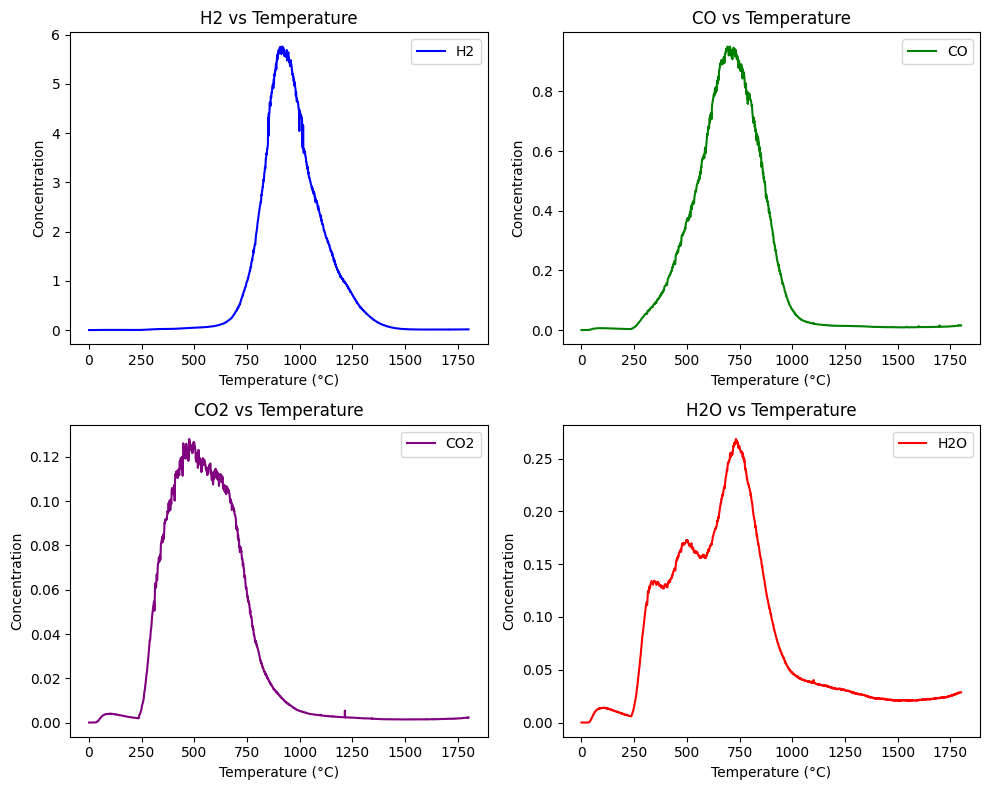

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pybeads
import os

# CSVファイルを読み込み
file_path = '/workspaces/Modulus/DESK/Peak_analysis/Y-Ac6(4)-H8.5(3).csv'
data = pd.read_csv(file_path, engine='python', nrows=1800)

# プロット対象の列名と色を設定
columns = ['H2', 'CO', 'CO2', 'H2O']
colors = ['b', 'g', 'purple', 'r']

# FigureオブジェクトとAxesを作成
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()  # 2x2のグリッドを1次元配列に変換

# 各列のデータをループでプロット
x = data['Temp.']
for i, (col, color) in enumerate(zip(columns, colors)):
    axs[i].plot(x, data[col], color=color, label=col)
    axs[i].set_title(f'{col} vs Temperature')
    axs[i].set_xlabel('Temperature (°C)')
    axs[i].set_ylabel('Concentration')
    axs[i].legend()

# プロットを調整して表示
plt.tight_layout()
plt.show()

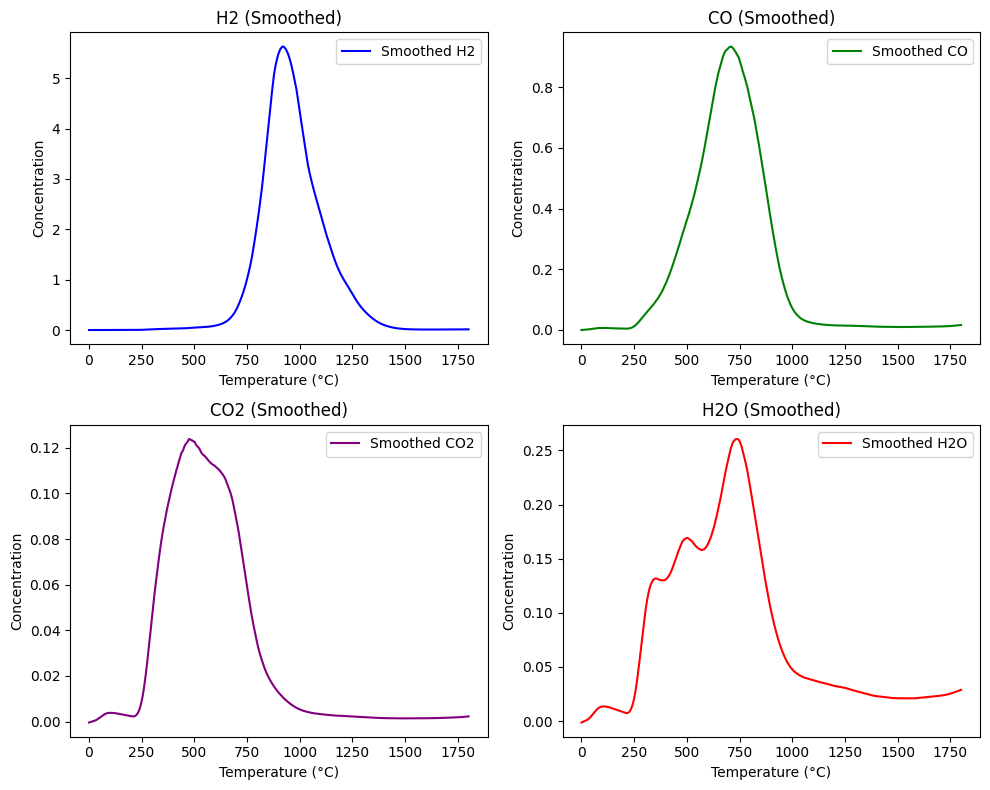

In [2]:
# シグナルをSavitzky-Golayフィルタで平滑化
smoothed_data = {
    'H2': savgol_filter(data['H2'], window_length=55, polyorder=1),
    'H2O': savgol_filter(data['H2O'], window_length=55, polyorder=1),
    'CO': savgol_filter(data['CO'], window_length=55, polyorder=1),
    'CO2': savgol_filter(data['CO2'], window_length=55, polyorder=1)
}

# プロットの設定
columns = ['H2', 'CO', 'CO2', 'H2O']
colors = ['b', 'g', 'purple', 'r']

# FigureとAxesを作成
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()  # 2x2のグリッドを1次元配列に変換
x = data['Temp.']

# 平滑化されたデータをプロット
for i, (col, color) in enumerate(zip(columns, colors)):
    axs[i].plot(x, smoothed_data[col], color=color, label=f'Smoothed {col}')
    axs[i].set_title(f'{col} (Smoothed)')
    axs[i].set_xlabel('Temperature (°C)')
    axs[i].set_ylabel('Concentration')
    axs[i].legend()

# プロットのレイアウト調整と表示
plt.tight_layout()
plt.show()

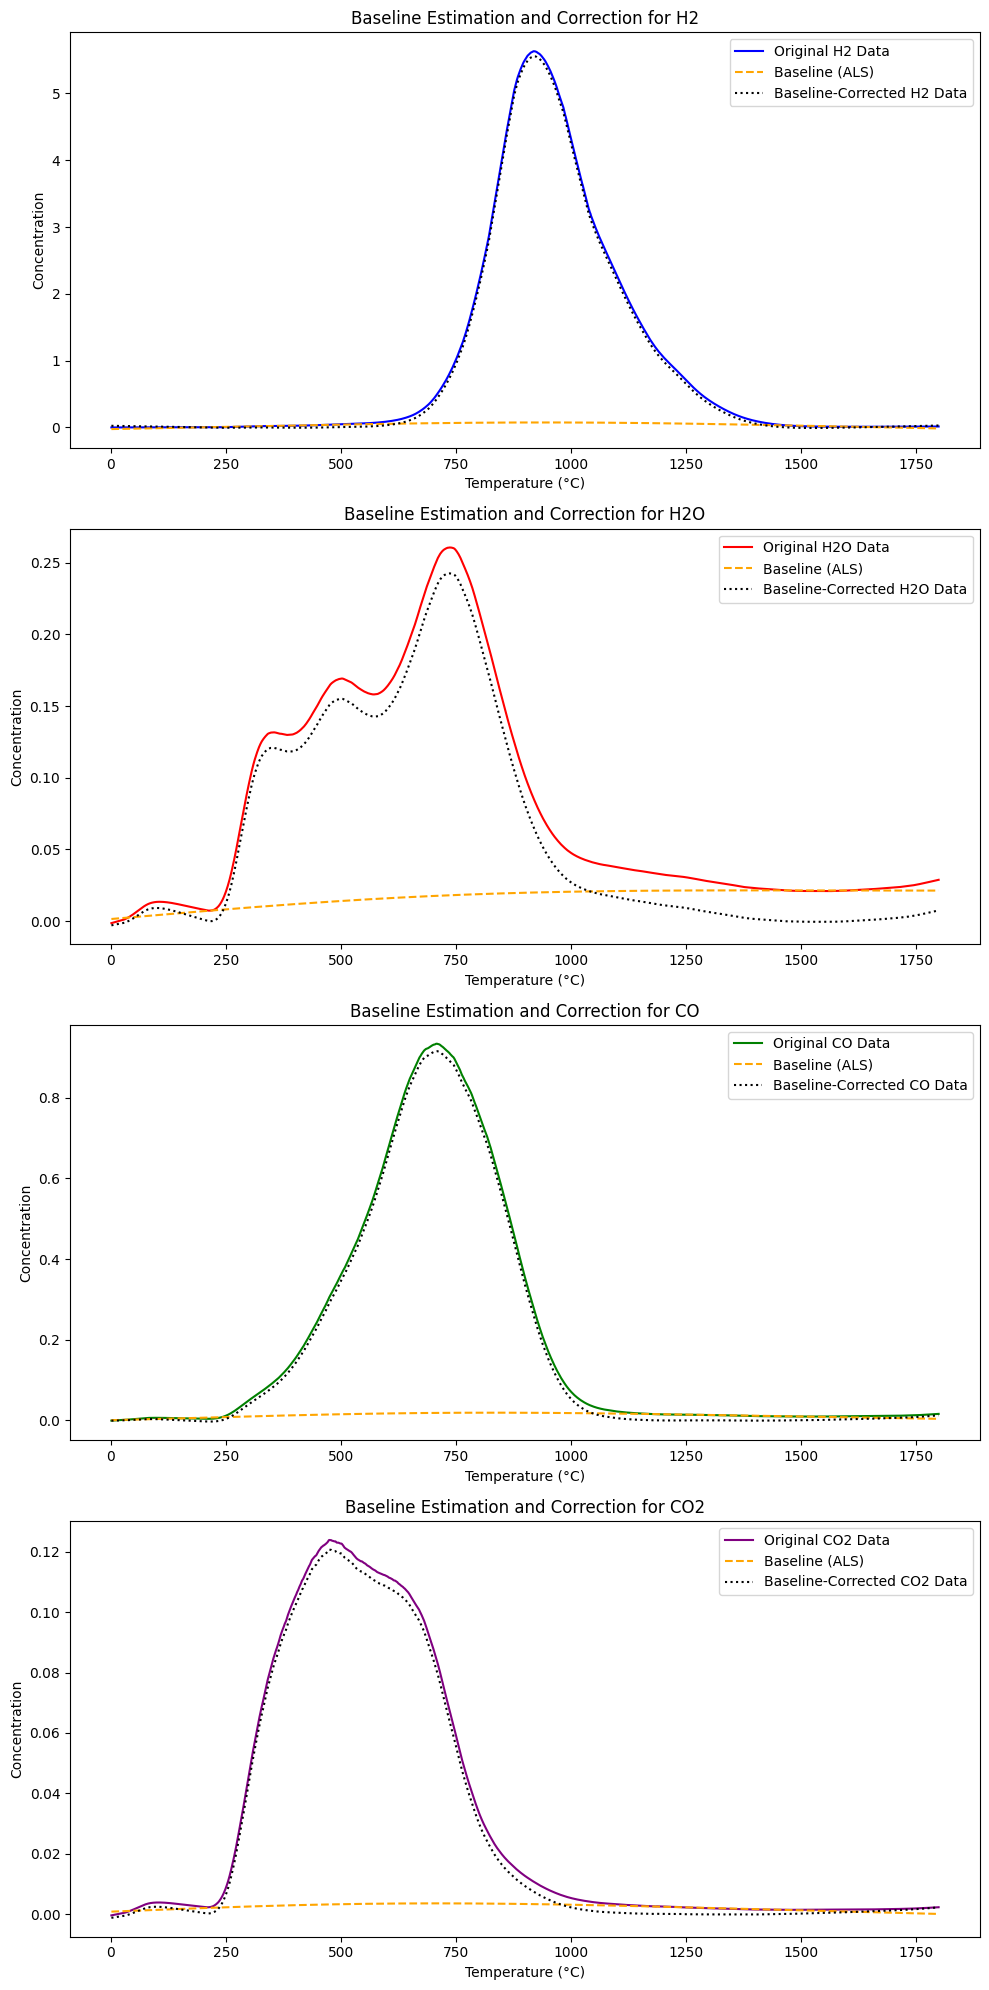

In [3]:
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix, spdiags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# Baseline ALS function
def baseline_als(y, lam=1e9, p=0.001, niter=10):
    L = len(y)
    D = csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

# 温度データ
x = data['Temp.']

# Baseline correction for each smoothed data series
corrected_data = {}
baselines = {}
for gas in ['H2', 'H2O', 'CO', 'CO2']:
    original_data = smoothed_data[gas]
    baseline = baseline_als(original_data)
    corrected = original_data - baseline
    baselines[gas] = baseline
    corrected_data[gas] = corrected

# Plotting original, baseline, and corrected data for each gas with temperature on the x-axis
fig, axs = plt.subplots(4, 1, figsize=(10, 20))
colors = {'H2': 'blue', 'H2O': 'red', 'CO': 'green', 'CO2': 'purple'}

for i, (gas, color) in enumerate(colors.items()):
    axs[i].plot(x, smoothed_data[gas], label=f'Original {gas} Data', color=color)
    axs[i].plot(x, baselines[gas], label='Baseline (ALS)', linestyle='--', color='orange')
    axs[i].plot(x, corrected_data[gas], label=f'Baseline-Corrected {gas} Data', linestyle=':', color='black')
    axs[i].set_title(f'Baseline Estimation and Correction for {gas}')
    axs[i].set_xlabel('Temperature (°C)')
    axs[i].set_ylabel('Concentration')
    axs[i].legend()

plt.tight_layout()
plt.show()


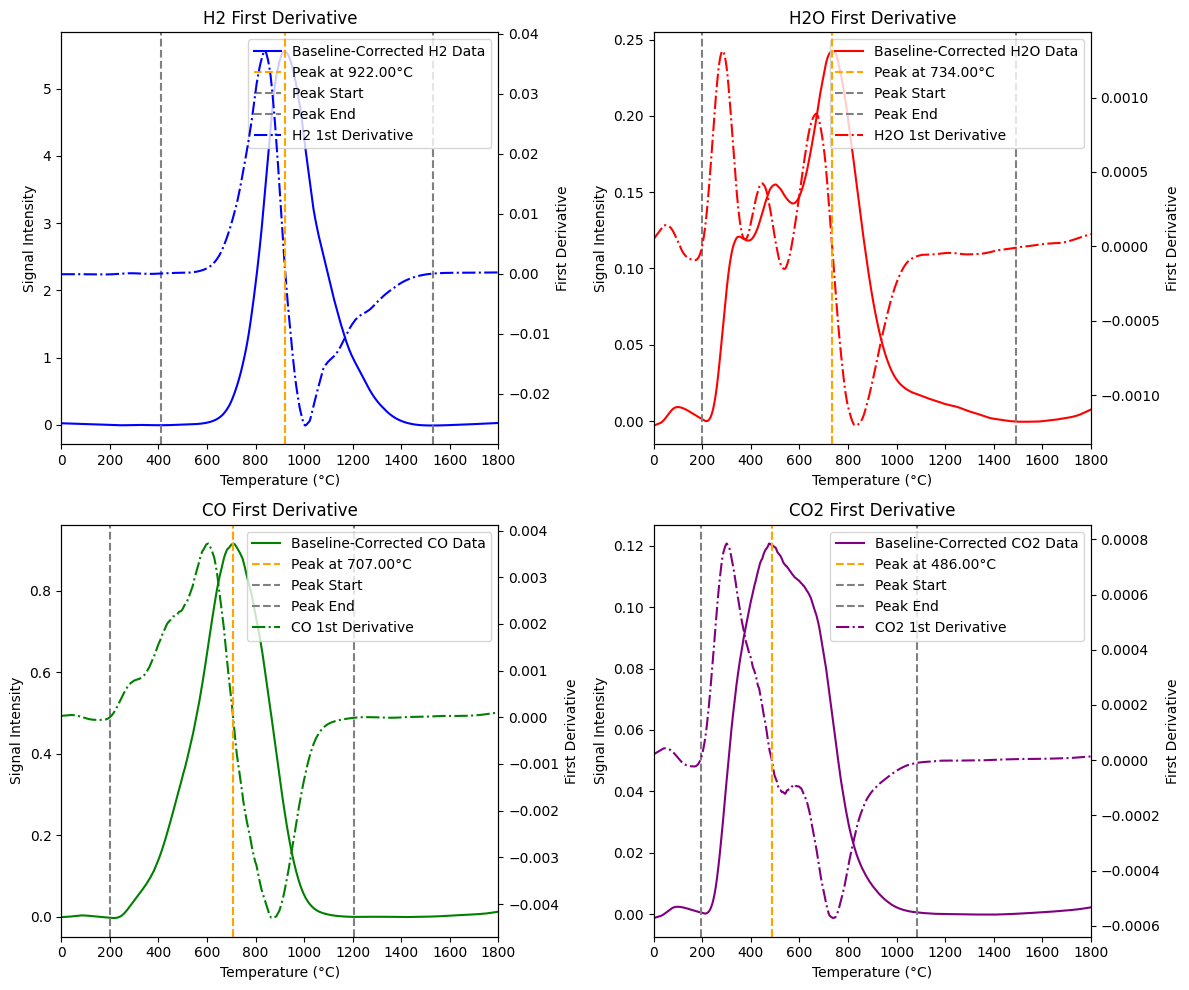

Peak Information:
     Peak Position (°C)  Peak Intensity  Peak Start Temperature (°C)  \
H2                  922        5.555673                          409   
H2O                 734        0.242342                          200   
CO                  707        0.915851                          201   
CO2                 486        0.120180                          195   

     Peak End Temperature (°C)  Peak Symmetry  
H2                        1529       0.073071  
H2O                       1491       0.151555  
CO                        1205      -0.006921  
CO2                       1083       0.312081  


In [5]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import os  # os モジュールをインポート
import math

# 傾きがゼロとみなすためのしきい値を設定
derivative_threshold = 0.00001  # 適宜調整可能

# 各ガスシグナルの1回微分を計算
derivatives = {}
peak_info = {}  # ピーク情報を格納する辞書

for gas, data_series in corrected_data.items():
    # 1回微分の計算
    first_derivative = np.gradient(data_series, x)
    # Savitzky-Golayフィルタでスムージング
    smoothed_first_derivative = savgol_filter(first_derivative, window_length=80, polyorder=1)
    derivatives[gas] = smoothed_first_derivative

    # 1回微分のゼロ交差点を検出
    zero_crossings = np.where(np.diff(np.sign(smoothed_first_derivative)) != 0)[0]

    if len(zero_crossings) > 0:
        # 各ゼロ交差点での元のデータの値を取得
        y_values_at_zero_crossings = data_series[zero_crossings]
        # 最大の y 値を持つゼロ交差点を選択
        max_y_idx = np.argmax(y_values_at_zero_crossings)
        peak_idx = zero_crossings[max_y_idx]
        peak_temperature = x[peak_idx]
        peak_intensity = data_series[peak_idx]

        # ピーク強度の半分の値を計算
        half_max = peak_intensity / 2

        # ピーク半値幅位置（左側）を見つける
        start_idx = peak_idx
        while start_idx > 0 and data_series[start_idx] > half_max:
            start_idx -= 1

        # ピーク開始温度を見つける（傾きがゼロになる点を探索）
        start_idx_peak = start_idx
        while start_idx_peak > 0 and abs(smoothed_first_derivative[start_idx_peak]) > derivative_threshold:
            start_idx_peak -= 1
        peak_start_temperature = x[start_idx_peak]

        # ピーク半値幅位置（右側）を見つける
        end_idx = peak_idx
        while end_idx < len(data_series) - 1 and data_series[end_idx] > half_max:
            end_idx += 1

        # ピーク終了温度を見つける（傾きがゼロになる点を探索）
        end_idx_peak = end_idx
        while end_idx_peak < len(data_series) - 1 and abs(smoothed_first_derivative[end_idx_peak]) > derivative_threshold:
            end_idx_peak += 1
        peak_end_temperature = x[end_idx_peak]

        # ピーク対称性を計算
        left_width = peak_temperature - peak_start_temperature
        right_width = peak_end_temperature - peak_temperature
        if left_width == 0:
            symmetry = math.log10(np.inf)  # 左幅が0の場合、対称性は無限大
        else:
            symmetry = math.log10(right_width / left_width)

        # ピーク情報を保存
        peak_info[gas] = {
            'Peak Position (°C)': peak_temperature,
            'Peak Intensity': peak_intensity,
            'Peak Start Temperature (°C)': peak_start_temperature,
            'Peak End Temperature (°C)': peak_end_temperature,
            'Peak Symmetry': symmetry
        }
    else:
        peak_info[gas] = {
            'Peak Position (°C)': None,
            'Peak Intensity': None,
            'Peak Start Temperature (°C)': None,
            'Peak End Temperature (°C)': None,
            'Peak Symmetry': None
        }

# ピーク情報をデータフレームに変換
peak_df = pd.DataFrame.from_dict(peak_info, orient='index')

# 入力ファイル名から出力ファイル名を生成
output_filename = f"{os.path.splitext(os.path.basename(file_path))[0]}_peak_info.csv"
peak_df.to_csv(output_filename)

# プロット作成
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
colors = {'H2': 'blue', 'H2O': 'red', 'CO': 'green', 'CO2': 'purple'}

# 各ガスの1回微分とピーク位置をプロット
for i, (gas, color) in enumerate(colors.items()):
    row, col = divmod(i, 2)
    ax = axs[row, col]
    ax.plot(x, corrected_data[gas], color=colors[gas], label=f'Baseline-Corrected {gas} Data')

    # 右側のy軸を作成
    ax2 = ax.twinx()
    ax2.plot(x, derivatives[gas], color=color, linestyle='-.', label=f'{gas} 1st Derivative')

    # ピーク位置の垂直線をプロット（ゼロ交差点が見つかった場合）
    if peak_info[gas]['Peak Position (°C)'] is not None:
        peak_temp = peak_info[gas]['Peak Position (°C)']
        ax.axvline(peak_temp, color='orange', linestyle='--', label=f'Peak at {peak_temp:.2f}°C')
        ax2.axvline(peak_temp, color='orange', linestyle='--')

        # ピーク開始温度と終了温度の垂直線をプロット
        start_temp = peak_info[gas]['Peak Start Temperature (°C)']
        end_temp = peak_info[gas]['Peak End Temperature (°C)']
        ax.axvline(start_temp, color='grey', linestyle='--', label='Peak Start')
        ax.axvline(end_temp, color='grey', linestyle='--', label='Peak End')

    else:
        ax.text(0.5, 0.5, 'No Peak Found', transform=ax.transAxes, fontsize=12, color='red', ha='center')

    # 凡例を統合
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper right')

    ax.set_title(f'{gas} First Derivative')
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Signal Intensity')
    ax2.set_ylabel('First Derivative')
    ax.set_xlim(0, 1800)

plt.tight_layout()
plt.show()

# ピーク情報を表示
print("Peak Information:")
print(peak_df)
